This is the LSTM Model

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from helper_functions import preprocess, predictions, is_gpu_working, visualize

%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 7.0)
is_gpu_working()

True

In [2]:
window_in = 7
window_out = 1
colsx = ['Cumulative True Cases','Free','Positively Tested','CR', 'Series_No']
colsy = ['Cumulative True Cases','Free','Positively Tested', 'Series_No']
input_shape = (window_in, len(colsx) - 1)
x_train, y_train, x_test, y_test, len_of_ser, num_windows_ser = preprocess(dataframe_csvpath = "data.csv", 
    cols_x = colsx, 
    cols_y = colsy, 
    window_in = window_in, 
    window_out = window_out, 
    data_div_frac = 0.99, 
    popu_size = 80000
)

In [3]:
def LSTM_MODEL():
    model = keras.Sequential(
        [
                               layers.LSTM(128, return_sequences=True, input_shape = input_shape, activation='selu'),
                               layers.LSTM(256, return_sequences=True, activation='selu'),
                               layers.LSTM(128, return_sequences=False, activation='relu'),
                               layers.Dense(window_out * (len(colsy)-1)),
                               layers.Reshape((window_out, (len(colsy )-1)))
        ]
    )
    print(model.summary())
    return model 

In [4]:
model = LSTM_MODEL()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 128)            68096     
_________________________________________________________________
lstm_1 (LSTM)                (None, 7, 256)            394240    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dense (Dense)                (None, 3)                 387       
_________________________________________________________________
reshape (Reshape)            (None, 1, 3)              0         
Total params: 659,843
Trainable params: 659,843
Non-trainable params: 0
_________________________________________________________________
None


In [5]:
model.compile(
    loss = 'mae',
    optimizer = keras.optimizers.Adam(),
    metrics = ['accuracy']
)

model.fit(
    x_train,
    y_train,
    batch_size = 32,
    epochs = 30,
    verbose = 2
)

model.evaluate(x_test, y_test, batch_size = 32, verbose = 2)

Epoch 1/30
11701/11701 - 947s - loss: 6.5304e-04 - accuracy: 0.8713
Epoch 2/30
11701/11701 - 945s - loss: 3.2104e-04 - accuracy: 0.8920
Epoch 3/30
11701/11701 - 955s - loss: 2.7657e-04 - accuracy: 0.8952
Epoch 4/30
11701/11701 - 938s - loss: 2.4512e-04 - accuracy: 0.8984
Epoch 5/30
11701/11701 - 933s - loss: 2.2907e-04 - accuracy: 0.8998
Epoch 6/30
11701/11701 - 931s - loss: 2.1607e-04 - accuracy: 0.9027
Epoch 7/30
11701/11701 - 931s - loss: 2.0876e-04 - accuracy: 0.9026
Epoch 8/30
11701/11701 - 926s - loss: 2.0330e-04 - accuracy: 0.9035
Epoch 9/30
11701/11701 - 942s - loss: 1.9915e-04 - accuracy: 0.9031
Epoch 10/30
11701/11701 - 968s - loss: 1.9400e-04 - accuracy: 0.9037
Epoch 11/30
11701/11701 - 942s - loss: 1.8852e-04 - accuracy: 0.9034
Epoch 12/30
11701/11701 - 952s - loss: 1.8664e-04 - accuracy: 0.9047
Epoch 13/30
11701/11701 - 978s - loss: 1.8128e-04 - accuracy: 0.9066
Epoch 14/30
11701/11701 - 971s - loss: 1.8141e-04 - accuracy: 0.9040
Epoch 15/30
11701/11701 - 952s - loss: 1.76

[0.00017185411707032472, 0.7680412530899048]

In [6]:
y_pred, mae = predictions(x_test, y_test, model, len_of_ser, num_windows_ser, window_in = 7, window_out = 1)

The mean absolute error is:  tf.Tensor(131.9906274221804, shape=(), dtype=float64)


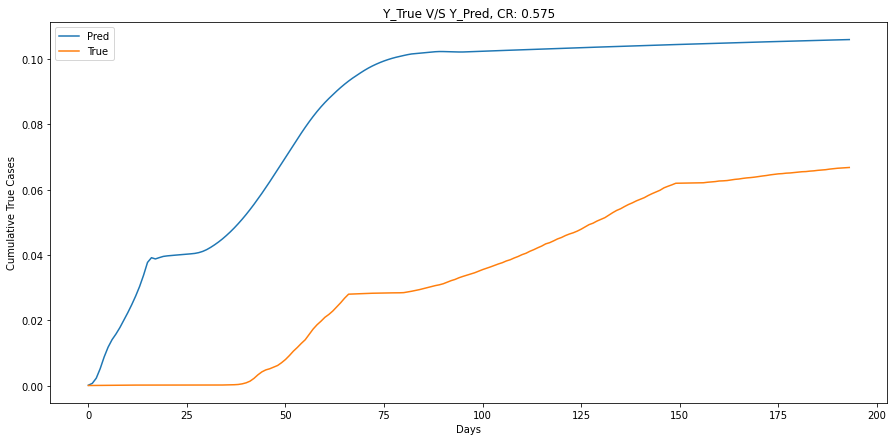

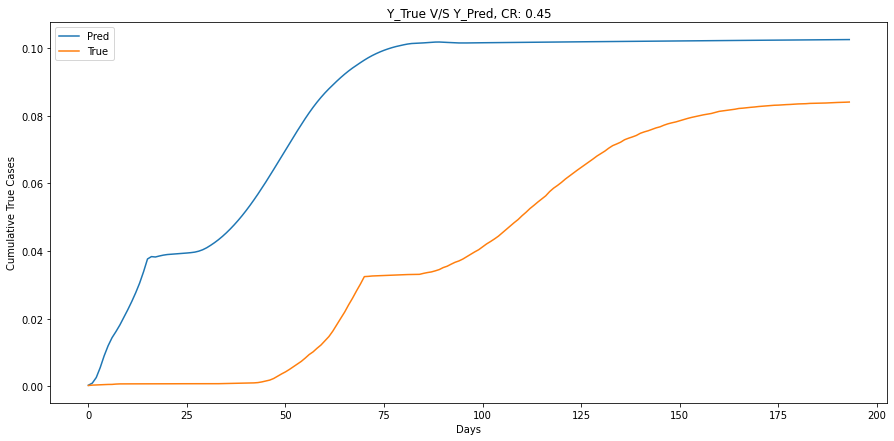

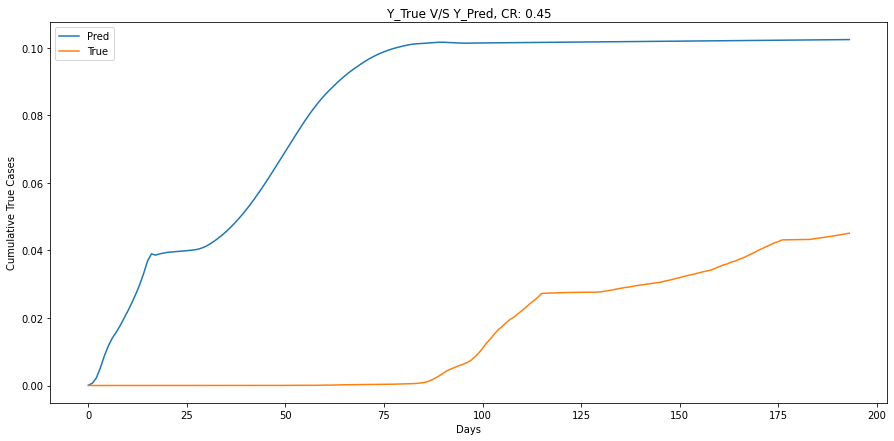

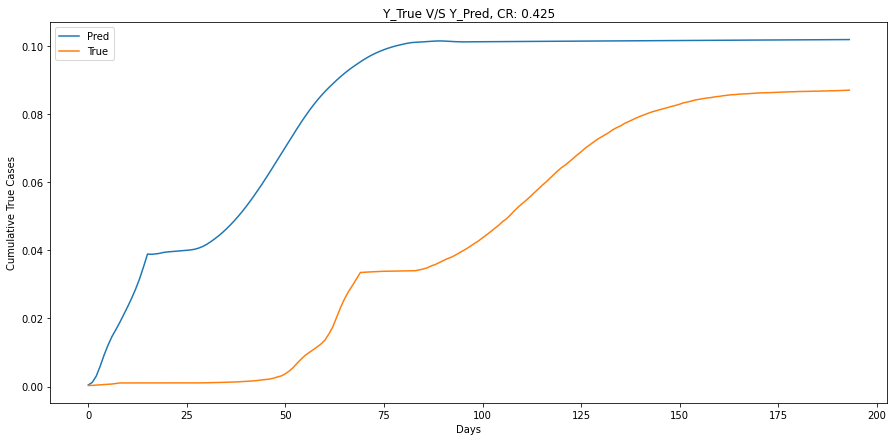

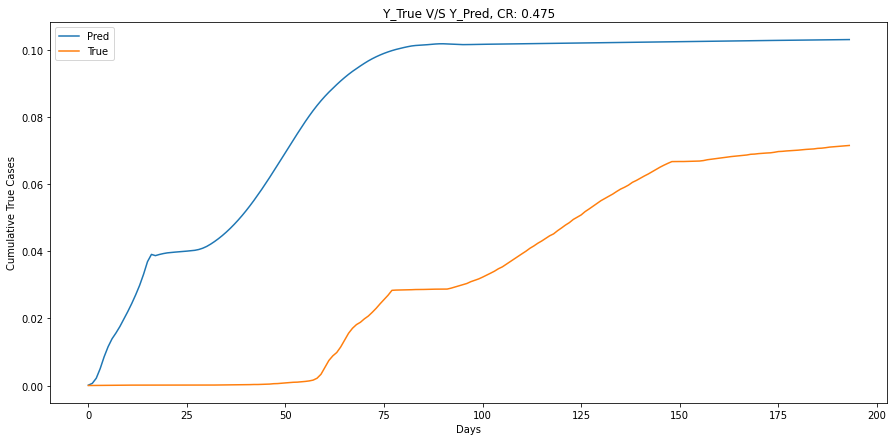

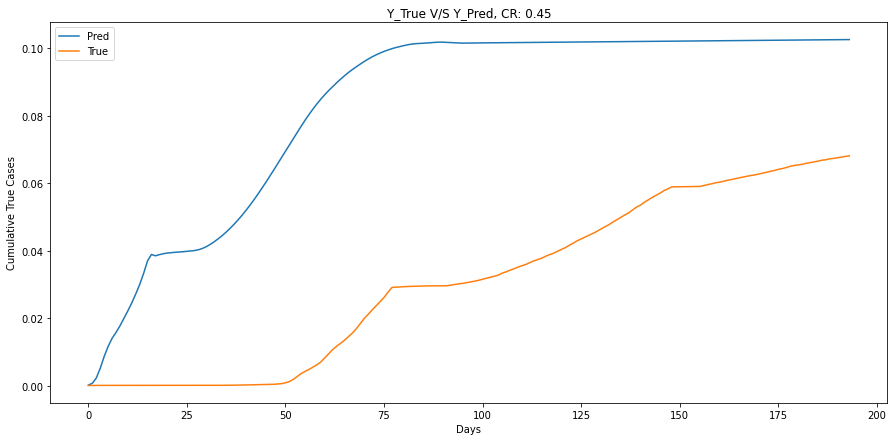

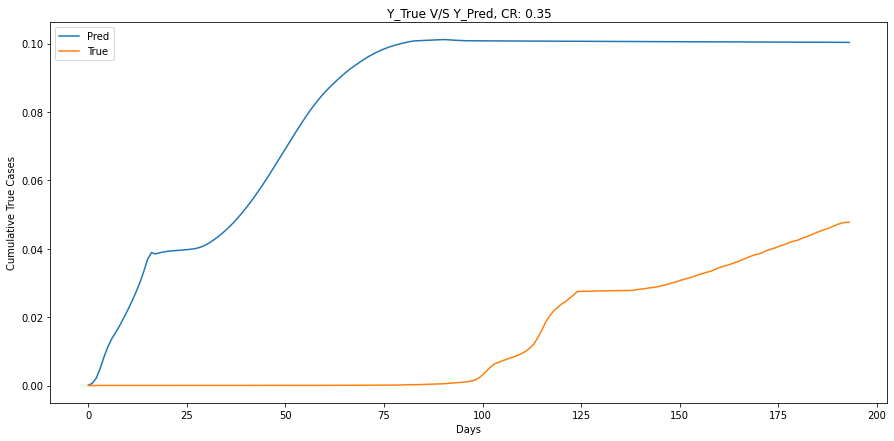

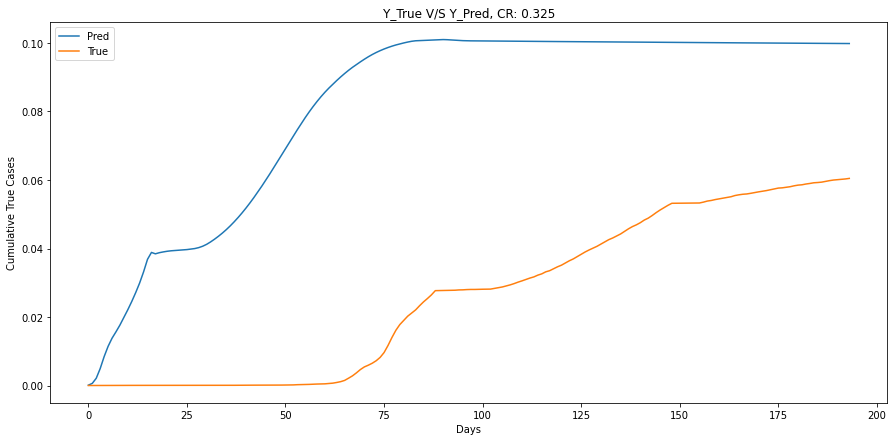

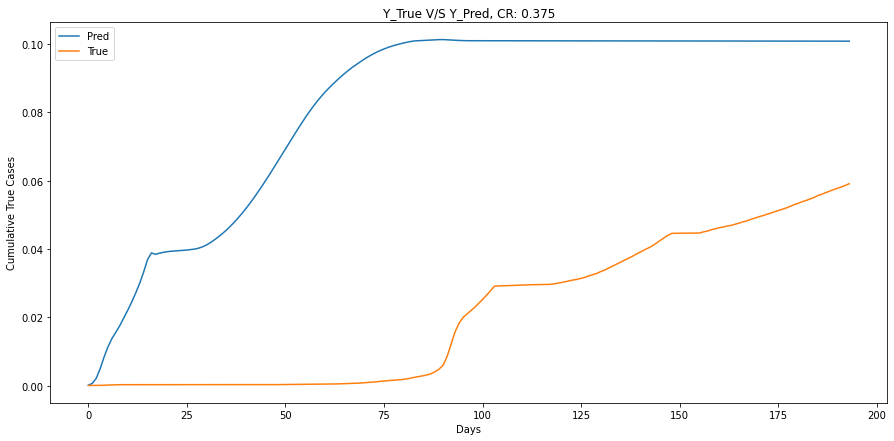

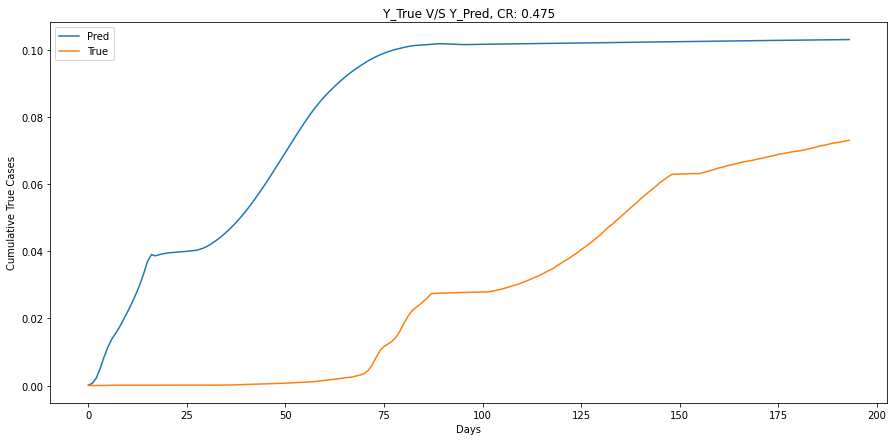

In [12]:
visualize(y_test, y_pred, x_test, window_out = window_out, num_plots = 10, num_win_ser = num_windows_ser, cols_y = colsy, col_idx = 0)